## Setup — install dependencies

Run the cell below once to install all required packages into the active kernel.
This project uses the `epl-betting` virtual environment — select it as your kernel in VS Code (`Ctrl+Shift+P` → *Select Kernel* → *EPL Betting (venv)*).

In [1]:
import subprocess, sys

# Install all required packages into whichever kernel is currently active
packages = [
    "pandas",
    "numpy",
    "scikit-learn",
    "tensorflow",
    "matplotlib",
    "seaborn",
    "ipykernel",
]

subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet"] + packages)
print("All packages installed.")

All packages installed.


# 01 — Feature Engineering

This notebook takes the raw `epl_final.csv` and produces a feature-rich dataset ready for modelling.

## What we build
For every match we compute features that would have been **knowable before kickoff**:
- Rolling form stats (win rate, goals, points) over last 5 and 10 matches
- Home/away-specific form
- Head-to-head history between the two teams
- ELO ratings (a self-updating strength estimate)

**Key rule**: for any match on date D, we only look at matches that finished *before* D. No leakage.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

## 1. Load & sort data

In [3]:
df = pd.read_csv('../epl_final.csv', parse_dates=['MatchDate'])

# Sort chronologically — this is essential for rolling features
df = df.sort_values('MatchDate').reset_index(drop=True)

print(f'Shape: {df.shape}')
print(f'Date range: {df.MatchDate.min().date()} → {df.MatchDate.max().date()}')
print(f'Seasons: {df.Season.nunique()}')
print(f'Teams ever: {sorted(set(df.HomeTeam) | set(df.AwayTeam))}')
df.head(3)

Shape: (9380, 22)
Date range: 2000-08-19 → 2025-05-05
Seasons: 25
Teams ever: ['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Bradford', 'Brentford', 'Brighton', 'Burnley', 'Cardiff', 'Charlton', 'Chelsea', 'Coventry', 'Crystal Palace', 'Derby', 'Everton', 'Fulham', 'Huddersfield', 'Hull', 'Ipswich', 'Leeds', 'Leicester', 'Liverpool', 'Luton', 'Man City', 'Man United', 'Middlesbrough', 'Newcastle', 'Norwich', "Nott'm Forest", 'Portsmouth', 'QPR', 'Reading', 'Sheffield United', 'Southampton', 'Stoke', 'Sunderland', 'Swansea', 'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Wigan', 'Wolves']


,Season,MatchDate,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
0,2000/01,2000-08-19,Charlton,Man City,4,0,H,2,0,H,17,8,14,4,6,6,13,12,1,2,0,0
1,2000/01,2000-08-19,Chelsea,West Ham,4,2,H,1,0,H,17,12,10,5,7,7,19,14,1,2,0,0
2,2000/01,2000-08-19,Coventry,Middlesbrough,1,3,A,1,1,D,6,16,3,9,8,4,15,21,5,3,1,0


In [4]:
# Quick sanity check — result distribution
print('Result distribution:')
print(df.FullTimeResult.value_counts(normalize=True).mul(100).round(1).to_string())

# Home wins dominate — this is the naive baseline to beat
print('\nNaive baseline (always predict H):', round((df.FullTimeResult == 'H').mean() * 100, 1), '%')

Result distribution:
FullTimeResult
H   45.800
A   29.500
D   24.700

Naive baseline (always predict H): 45.8 %


## 2. Rolling form features

For each match we compute per-team rolling stats from the **last 5 and last 10 matches**.

We keep two separate histories per team:
- `all_matches` — used for overall form
- `home_matches` / `away_matches` — used for venue-specific form

We iterate row-by-row in date order so there is zero leakage.

In [5]:
def rolling_stats(history, n):
    """
    Given a list of past match dicts, return aggregate stats over the last n matches.
    Each dict has: goals_for, goals_against, result ('W'/'D'/'L'), points
    Returns a dict of features. Returns NaN-filled dict if not enough history.
    """
    recent = history[-n:] if len(history) >= n else history
    if len(recent) == 0:
        return {
            f'win_rate_{n}': np.nan,
            f'draw_rate_{n}': np.nan,
            f'loss_rate_{n}': np.nan,
            f'goals_scored_avg_{n}': np.nan,
            f'goals_conceded_avg_{n}': np.nan,
            f'goal_diff_avg_{n}': np.nan,
            f'points_per_game_{n}': np.nan,
        }
    m = len(recent)
    wins   = sum(1 for r in recent if r['result'] == 'W')
    draws  = sum(1 for r in recent if r['result'] == 'D')
    losses = sum(1 for r in recent if r['result'] == 'L')
    gf     = sum(r['goals_for']     for r in recent)
    ga     = sum(r['goals_against'] for r in recent)
    pts    = wins * 3 + draws * 1
    return {
        f'win_rate_{n}':          wins   / m,
        f'draw_rate_{n}':         draws  / m,
        f'loss_rate_{n}':         losses / m,
        f'goals_scored_avg_{n}':  gf     / m,
        f'goals_conceded_avg_{n}':ga     / m,
        f'goal_diff_avg_{n}':    (gf-ga) / m,
        f'points_per_game_{n}':   pts    / m,
    }

In [6]:
# Initialise per-team histories
# all_hist  : every match regardless of venue
# home_hist : only matches played at home
# away_hist : only matches played away
all_hist  = defaultdict(list)
home_hist = defaultdict(list)
away_hist = defaultdict(list)

feature_rows = []

for _, row in df.iterrows():
    ht = row['HomeTeam']
    at = row['AwayTeam']
    res = row['FullTimeResult']   # 'H', 'D', 'A'
    hg  = row['FullTimeHomeGoals']
    ag  = row['FullTimeAwayGoals']

    # ---- Compute features BEFORE updating history ----
    feats = {}

    # Overall rolling stats for home team
    for n in [5, 10]:
        s = rolling_stats(all_hist[ht], n)
        feats.update({f'home_{k}': v for k, v in s.items()})

    # Home-venue-specific stats for home team
    for n in [5, 10]:
        s = rolling_stats(home_hist[ht], n)
        feats.update({f'home_venue_{k}': v for k, v in s.items()})

    # Overall rolling stats for away team
    for n in [5, 10]:
        s = rolling_stats(all_hist[at], n)
        feats.update({f'away_{k}': v for k, v in s.items()})

    # Away-venue-specific stats for away team
    for n in [5, 10]:
        s = rolling_stats(away_hist[at], n)
        feats.update({f'away_venue_{k}': v for k, v in s.items()})

    feature_rows.append(feats)

    # ---- Update history AFTER computing features ----
    home_result = 'W' if res == 'H' else ('D' if res == 'D' else 'L')
    away_result = 'W' if res == 'A' else ('D' if res == 'D' else 'L')

    home_match = {'goals_for': hg, 'goals_against': ag, 'result': home_result}
    away_match = {'goals_for': ag, 'goals_against': hg, 'result': away_result}

    all_hist[ht].append(home_match)
    all_hist[at].append(away_match)
    home_hist[ht].append(home_match)
    away_hist[at].append(away_match)

form_df = pd.DataFrame(feature_rows)
print(f'Form features shape: {form_df.shape}')
form_df.head(3)

Form features shape: (9380, 56)


,home_win_rate_5,home_draw_rate_5,home_loss_rate_5,home_goals_scored_avg_5,home_goals_conceded_avg_5,home_goal_diff_avg_5,home_points_per_game_5,home_win_rate_10,home_draw_rate_10,home_loss_rate_10,home_goals_scored_avg_10,home_goals_conceded_avg_10,home_goal_diff_avg_10,home_points_per_game_10,home_venue_win_rate_5,home_venue_draw_rate_5,home_venue_loss_rate_5,home_venue_goals_scored_avg_5,home_venue_goals_conceded_avg_5,home_venue_goal_diff_avg_5,home_venue_points_per_game_5,home_venue_win_rate_10,home_venue_draw_rate_10,home_venue_loss_rate_10,home_venue_goals_scored_avg_10,home_venue_goals_conceded_avg_10,home_venue_goal_diff_avg_10,home_venue_points_per_game_10,away_win_rate_5,away_draw_rate_5,away_loss_rate_5,away_goals_scored_avg_5,away_goals_conceded_avg_5,away_goal_diff_avg_5,away_points_per_game_5,away_win_rate_10,away_draw_rate_10,away_loss_rate_10,away_goals_scored_avg_10,away_goals_conceded_avg_10,away_goal_diff_avg_10,away_points_per_game_10,away_venue_win_rate_5,away_venue_draw_rate_5,away_venue_loss_rate_5,away_venue_goals_scored_avg_5,away_venue_goals_conceded_avg_5,away_venue_goal_diff_avg_5,away_venue_points_per_game_5,away_venue_win_rate_10,away_venue_draw_rate_10,away_venue_loss_rate_10,away_venue_goals_scored_avg_10,away_venue_goals_conceded_avg_10,away_venue_goal_diff_avg_10,away_venue_points_per_game_10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Head-to-head features

When Arsenal play Chelsea, their direct history matters separately from general form. We track the last 5 meetings between each ordered pair (home, away).

In [7]:
h2h_hist = defaultdict(list)  # key: (home_team, away_team)
h2h_rows = []

for _, row in df.iterrows():
    ht  = row['HomeTeam']
    at  = row['AwayTeam']
    res = row['FullTimeResult']
    n   = 5

    # Look up history for BOTH orderings (this pair regardless of who was home)
    key1 = (ht, at)
    key2 = (at, ht)
    combined = sorted(
        h2h_hist[key1] + h2h_hist[key2],
        key=lambda x: x['date']
    )[-n:]

    if len(combined) == 0:
        h2h_rows.append({'h2h_home_wins': np.nan, 'h2h_draws': np.nan,
                         'h2h_away_wins': np.nan, 'h2h_matches': 0})
    else:
        # Normalise so 'home' always means ht in this current match
        hw = sum(1 for m in combined if m['home_team'] == ht and m['result'] == 'H'
                                     or m['home_team'] == at and m['result'] == 'A')
        aw = sum(1 for m in combined if m['home_team'] == at and m['result'] == 'H'
                                     or m['home_team'] == ht and m['result'] == 'A')
        dr = len(combined) - hw - aw
        m_count = len(combined)
        h2h_rows.append({
            'h2h_home_wins': hw / m_count,
            'h2h_draws':     dr / m_count,
            'h2h_away_wins': aw / m_count,
            'h2h_matches':   m_count,
        })

    # Update history
    h2h_hist[key1].append({'date': row['MatchDate'], 'home_team': ht,
                            'away_team': at, 'result': res})

h2h_df = pd.DataFrame(h2h_rows)
print(f'H2H features shape: {h2h_df.shape}')
h2h_df.head(3)

H2H features shape: (9380, 4)


,h2h_home_wins,h2h_draws,h2h_away_wins,h2h_matches
0,NaN,NaN,NaN,0
1,NaN,NaN,NaN,0
2,NaN,NaN,NaN,0


## 4. ELO ratings

ELO is a self-updating skill rating borrowed from chess. After each match:
- The winner's rating goes up, the loser's goes down
- How much depends on the **expected** result — beating a much stronger opponent earns more points
- Draws are handled by giving each team half credit

This compresses all historical form into a single number per team.

In [8]:
K = 32       # learning rate — how fast ratings shift per match
BASE = 1500  # starting ELO for any team
HOME_ADV = 100  # ELO bonus for playing at home (well-established in football)

elo_ratings = defaultdict(lambda: BASE)
elo_rows = []

for _, row in df.iterrows():
    ht  = row['HomeTeam']
    at  = row['AwayTeam']
    res = row['FullTimeResult']

    r_home = elo_ratings[ht]
    r_away = elo_ratings[at]

    # Expected score for home team (includes home advantage)
    exp_home = 1 / (1 + 10 ** ((r_away - (r_home + HOME_ADV)) / 400))
    exp_away = 1 - exp_home

    # Record BEFORE updating
    elo_rows.append({
        'home_elo':  r_home,
        'away_elo':  r_away,
        'elo_diff':  r_home - r_away,
        'elo_exp_home': exp_home,  # model's prior probability of home win
    })

    # Actual scores
    if res == 'H':
        actual_home, actual_away = 1, 0
    elif res == 'D':
        actual_home, actual_away = 0.5, 0.5
    else:
        actual_home, actual_away = 0, 1

    # Update ratings
    elo_ratings[ht] += K * (actual_home - exp_home)
    elo_ratings[at] += K * (actual_away - exp_away)

elo_df = pd.DataFrame(elo_rows)
print(f'ELO features shape: {elo_df.shape}')
elo_df.describe()

ELO features shape: (9380, 4)


,home_elo,away_elo,elo_diff,elo_exp_home
count,9380.000,9380.000,9380.000,9380.000
mean,1568.446,1567.314,1.132,0.620
std,117.323,117.350,165.551,0.192
min,1221.028,1217.290,-648.550,0.041
25%,1486.756,1485.646,-103.634,0.495
50%,1541.386,1539.646,0.889,0.641
75%,1642.069,1641.417,106.511,0.767
max,1977.149,1978.220,585.133,0.981


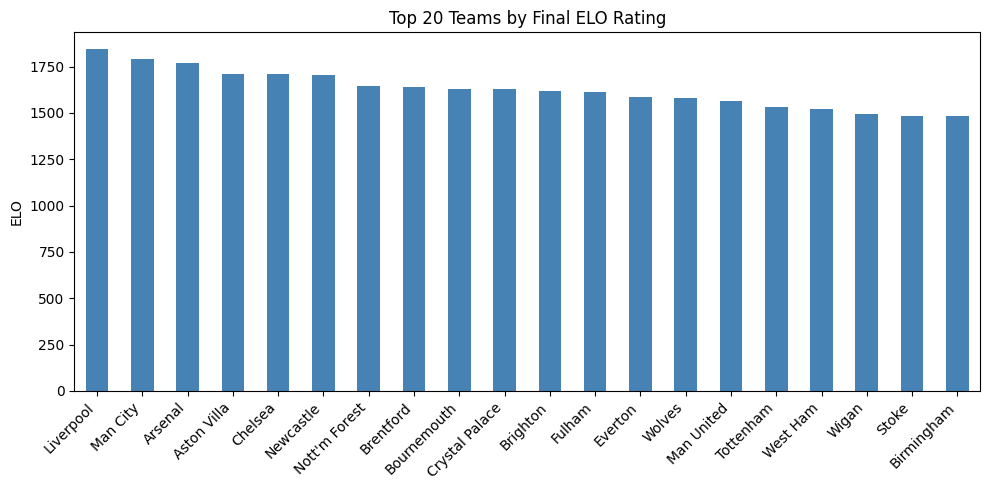

In [9]:
# Visualise final ELO ratings — sanity check
final_elos = dict(elo_ratings)
elo_series = pd.Series(final_elos).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 5))
elo_series.plot(kind='bar', color='steelblue')
plt.title('Top 20 Teams by Final ELO Rating')
plt.ylabel('ELO')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Assemble full feature matrix

In [10]:
# Concatenate all feature blocks with the original index columns
meta = df[['Season', 'MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeResult']].copy()

features = pd.concat([meta, form_df, h2h_df, elo_df], axis=1)

print(f'Full feature matrix: {features.shape}')
print(f'\nColumns ({len(features.columns)}):')
for c in features.columns:
    print(' ', c)

Full feature matrix: (9380, 69)

Columns (69):
  Season
  MatchDate
  HomeTeam
  AwayTeam
  FullTimeResult
  home_win_rate_5
  home_draw_rate_5
  home_loss_rate_5
  home_goals_scored_avg_5
  home_goals_conceded_avg_5
  home_goal_diff_avg_5
  home_points_per_game_5
  home_win_rate_10
  home_draw_rate_10
  home_loss_rate_10
  home_goals_scored_avg_10
  home_goals_conceded_avg_10
  home_goal_diff_avg_10
  home_points_per_game_10
  home_venue_win_rate_5
  home_venue_draw_rate_5
  home_venue_loss_rate_5
  home_venue_goals_scored_avg_5
  home_venue_goals_conceded_avg_5
  home_venue_goal_diff_avg_5
  home_venue_points_per_game_5
  home_venue_win_rate_10
  home_venue_draw_rate_10
  home_venue_loss_rate_10
  home_venue_goals_scored_avg_10
  home_venue_goals_conceded_avg_10
  home_venue_goal_diff_avg_10
  home_venue_points_per_game_10
  away_win_rate_5
  away_draw_rate_5
  away_loss_rate_5
  away_goals_scored_avg_5
  away_goals_conceded_avg_5
  away_goal_diff_avg_5
  away_points_per_game_5
  awa

## 6. Drop rows with insufficient history

The first ~10 matches for each team will have NaN rolling features because there's not enough history. We drop those.

In [11]:
before = len(features)

# Drop any row that has a NaN in our actual feature columns (not meta columns)
feature_cols = [c for c in features.columns if c not in
                ['Season', 'MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeResult', 'h2h_matches']]

features_clean = features.dropna(subset=feature_cols).reset_index(drop=True)

after = len(features_clean)
print(f'Dropped {before - after} rows with insufficient history ({after} remaining)')
print(f'NaN check: {features_clean[feature_cols].isna().sum().sum()} NaNs remaining')

Dropped 794 rows with insufficient history (8586 remaining)
NaN check: 0 NaNs remaining


## 7. Encode the target

`H` → 0, `D` → 1, `A` → 2

This maps to the three output neurons in the network.

In [12]:
result_map = {'H': 0, 'D': 1, 'A': 2}
features_clean['target'] = features_clean['FullTimeResult'].map(result_map)

print('Target distribution:')
print(features_clean['target'].value_counts().sort_index().rename({0:'H(0)', 1:'D(1)', 2:'A(2)'}))

Target distribution:
target
H(0)    3925
D(1)    2101
A(2)    2560
Name: count, dtype: int64


## 8. Train / Validation / Test split

We split **by season**, not randomly. Mixing future data into training would be leakage.

| Split | Seasons | Purpose |
|---|---|---|
| Train | 2000/01 – 2017/18 | Learn from |
| Validation | 2018/19 – 2021/22 | Tune hyperparameters |
| Test | 2022/23 – 2024/25 | Final betting simulation |

In [13]:
train_seasons = [s for s in features_clean['Season'].unique() if s <= '2017/18']
val_seasons   = [s for s in features_clean['Season'].unique() if '2018/19' <= s <= '2021/22']
test_seasons  = [s for s in features_clean['Season'].unique() if s >= '2022/23']

train = features_clean[features_clean['Season'].isin(train_seasons)]
val   = features_clean[features_clean['Season'].isin(val_seasons)]
test  = features_clean[features_clean['Season'].isin(test_seasons)]

print(f'Train: {len(train):,} matches ({train.Season.min()} → {train.Season.max()})')
print(f'Val:   {len(val):,} matches ({val.Season.min()} → {val.Season.max()})')
print(f'Test:  {len(test):,} matches ({test.Season.min()} → {test.Season.max()})')

Train: 6,058 matches (2000/01 → 2017/18)
Val:   1,468 matches (2018/19 → 2021/22)
Test:  1,060 matches (2022/23 → 2024/25)


## 9. Normalise features

Neural networks are sensitive to scale. We fit a `StandardScaler` on **training data only**, then apply it to val and test. Never fit on val/test.

In [14]:
from sklearn.preprocessing import StandardScaler

# Feature columns only (drop meta + target)
drop_cols = ['Season', 'MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeResult',
             'target', 'h2h_matches']
feat_cols = [c for c in features_clean.columns if c not in drop_cols]

X_train = train[feat_cols].values
X_val   = val[feat_cols].values
X_test  = test[feat_cols].values

y_train = train['target'].values
y_val   = val['target'].values
y_test  = test['target'].values

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)   # fit + transform on train
X_val_s   = scaler.transform(X_val)          # transform only
X_test_s  = scaler.transform(X_test)         # transform only

print(f'Feature count: {len(feat_cols)}')
print(f'X_train: {X_train_s.shape},  y_train: {y_train.shape}')
print(f'X_val:   {X_val_s.shape},    y_val:   {y_val.shape}')
print(f'X_test:  {X_test_s.shape},   y_test:  {y_test.shape}')
print(f'\nFeature names:')
for i, f in enumerate(feat_cols):
    print(f'  {i:2d}  {f}')

Feature count: 63
X_train: (6058, 63),  y_train: (6058,)
X_val:   (1468, 63),    y_val:   (1468,)
X_test:  (1060, 63),   y_test:  (1060,)

Feature names:
   0  home_win_rate_5
   1  home_draw_rate_5
   2  home_loss_rate_5
   3  home_goals_scored_avg_5
   4  home_goals_conceded_avg_5
   5  home_goal_diff_avg_5
   6  home_points_per_game_5
   7  home_win_rate_10
   8  home_draw_rate_10
   9  home_loss_rate_10
  10  home_goals_scored_avg_10
  11  home_goals_conceded_avg_10
  12  home_goal_diff_avg_10
  13  home_points_per_game_10
  14  home_venue_win_rate_5
  15  home_venue_draw_rate_5
  16  home_venue_loss_rate_5
  17  home_venue_goals_scored_avg_5
  18  home_venue_goals_conceded_avg_5
  19  home_venue_goal_diff_avg_5
  20  home_venue_points_per_game_5
  21  home_venue_win_rate_10
  22  home_venue_draw_rate_10
  23  home_venue_loss_rate_10
  24  home_venue_goals_scored_avg_10
  25  home_venue_goals_conceded_avg_10
  26  home_venue_goal_diff_avg_10
  27  home_venue_points_per_game_10
  28

## 10. Quick EDA — do our features correlate with the outcome?

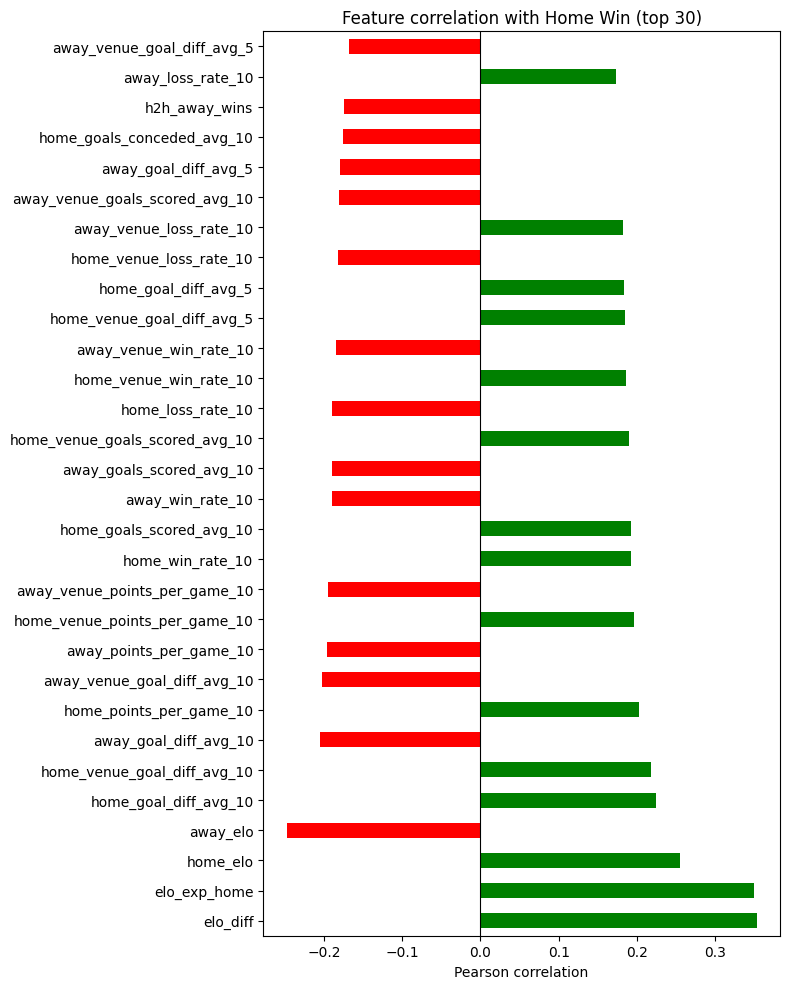


Top 10 most correlated features with home win:
elo_diff                       0.353
elo_exp_home                   0.349
home_elo                       0.255
away_elo                      -0.247
home_goal_diff_avg_10          0.224
home_venue_goal_diff_avg_10    0.218
away_goal_diff_avg_10         -0.206
home_points_per_game_10        0.203
away_venue_goal_diff_avg_10   -0.202
away_points_per_game_10       -0.196


In [15]:
# Correlation of each feature with a binary 'home win' label — just to sense-check
eda = train[feat_cols].copy()
eda['home_win'] = (train['target'] == 0).astype(int)

corr = eda.corr()['home_win'].drop('home_win').sort_values(key=abs, ascending=False)

plt.figure(figsize=(8, 10))
corr.head(30).plot(kind='barh', color=['green' if v > 0 else 'red' for v in corr.head(30)])
plt.title('Feature correlation with Home Win (top 30)')
plt.xlabel('Pearson correlation')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

print('\nTop 10 most correlated features with home win:')
print(corr.head(10).to_string())

## 11. Save everything

We save the processed arrays as `.npz` and also a CSV with all features for inspection.

In [16]:
import os, json

out_dir = '.'

# Save numpy arrays
np.savez(
    os.path.join(out_dir, 'processed_data.npz'),
    X_train=X_train_s, y_train=y_train,
    X_val=X_val_s,     y_val=y_val,
    X_test=X_test_s,   y_test=y_test,
)

# Save feature names for reference in other notebooks
with open(os.path.join(out_dir, 'feature_names.json'), 'w') as f:
    json.dump(feat_cols, f, indent=2)

# Save full feature CSV for inspection
features_clean.to_csv(os.path.join(out_dir, 'features_full.csv'), index=False)

# Save test meta for betting simulation later
test[['Season', 'MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeResult', 'target']].to_csv(
    os.path.join(out_dir, 'test_meta.csv'), index=False
)

print('Saved:')
print('  processed_data.npz  — scaled X/y arrays for train/val/test')
print('  feature_names.json  — ordered list of feature names')
print('  features_full.csv   — human-readable feature matrix')
print('  test_meta.csv       — match metadata for betting sim')
print(f'\nFinal feature count: {len(feat_cols)}')
print(f'Train/Val/Test sizes: {X_train_s.shape[0]} / {X_val_s.shape[0]} / {X_test_s.shape[0]}')

Saved:
  processed_data.npz  — scaled X/y arrays for train/val/test
  feature_names.json  — ordered list of feature names
  features_full.csv   — human-readable feature matrix
  test_meta.csv       — match metadata for betting sim

Final feature count: 63
Train/Val/Test sizes: 6058 / 1468 / 1060
